# Character Segmentation - Data Mining
Simple UI for creating data for character separation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
# Import Widgets
from ipywidgets import Button, HBox, VBox
from IPython.display import display, clear_output
# Timestamp
import time

# Import costume functions, corresponding to notebooks
from ocr import page, words, charSeg
from ocr.normalization import imageNorm
# Helper functions - ploting and resizing
from ocr.helpers import implt, resize

/home/breta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading Segmantation model:
INFO:tensorflow:Restoring parameters from models/gap-clas/CNN-CG
INFO:tensorflow:Restoring parameters from models/gap-clas/RNN/Bi-RNN-new


### Global variables

In [2]:
IMG = "text"

## Load image

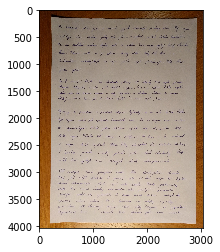

In [3]:
image = cv2.cvtColor(cv2.imread("data/pagedet/%s.jpg" % IMG), cv2.COLOR_BGR2RGB)
implt(image)

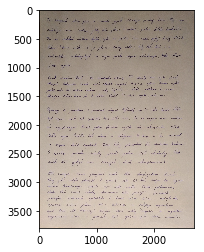

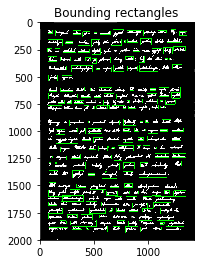

In [4]:
# Crop image and get bounding boxes
crop = page.detection(image)
implt(crop)
bBoxes = words.detection(crop)

# Simple UI using widgets

In [9]:
class Cycler:
    """ Cycle through boxes, save data """
    width = 120
    height = 60
    step = 2

    def __init__(self, image, boxes, idx):
        self.boxes = boxes       # Array of bounding boxes
        self.image = image       # Whole image
        self.index = idx-1         # Index of current bounding box
        self.pos = 0             # Position po slider
        self.actual = image      # Current image of word
        self.actualPos = image   # Current slider image
        
        bGap = Button(description="Gap")
        bLet = Button(description="Letter")
        bNex = Button(description="Label Image")
        bNexi = Button(description="Next Image")

        bGap.on_click(self.save)
        bLet.on_click(self.saveLetter)
        bNex.on_click(self.nextPos)
        bNexi.on_click(self.nextImgButton)

        self.buttons = HBox([VBox([bGap, bLet]),
                             VBox([bNex, bNexi])])
        
        self.nextImgButton()
        
    def saveLetter(self, b):
        self.save(b, val=0)
        
    def save(self, b, val=1):
        """ Saving current position of slider """
        if self.pos != -1:
            cv2.imwrite("data/gapdet/large/%s_%s/%s_%s.jpg" %
                        (IMG, self.index, val, self.pos), self.actualPos)
            self.nextPos(b)
        
    def prevPos(self, b):
        self.nextPos(b, step=-self.step)
        
    def nextSmallPos(self, b): 
        self.nextPos(b, step=1)
        
    def segment(self):
        """ Only for demonstration of current classifier """
        charSeg.segmentation(self.actual, RNN=True, debug=True)        
        
    def nextPos(self, b, step=0):
        """ Sliding over image """
        
        if step == 0:
            step = self.step
        
        if self.pos == -1:
            os.mkdir('data/gapdet/large/%s_%s' % (IMG, self.index))
            step = 1
        
        # Clearing jupyter output for new image
        clear_output()
        display(self.buttons)
        
        self.pos += step
        
        if self.pos < len(self.actual[0]) - self.width:            
            img = self.actual[0:self.height, self.pos:self.pos + self.width]
            self.actualPos = img
            
            # Drawing center vertical line for better visualizastion, need convert to RGB
            ii = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            cv2.line(ii,
                     ((int)(self.width/2),0),
                     ((int)(self.width/2),
                      self.height),
                     (0,255,0), 1)
            implt(ii)
        else:
            if self.nextImg() == -1:
                print("END")
                
    def nextImgButton(self, b=None):
        clear_output()
        display(self.buttons)
        self.nextImg()

    def nextImg(self):
        """ Getting next image from the array """
        
        self.pos = -1                    
        self.index += 1
        
        if self.index < len(self.boxes):
            b = self.boxes[self.index]
            x1, y1, x2, y2 = b
            
            # Cuting out the word image and resizing to standard height
            img = self.image[y1:y2, x1:x2]
            img = resize(img, self.height, True)
            
            implt(img, t='Original')            
            self.actual = imageNorm(
                img, self.height, borderSize=int(self.width/2), hystNorm=True)
            implt(self.actual, 'gray', 'Preprocess')
            self.segment()
            
            # Printing index for recovery
            print("Index: " + str(self.index))
            
            return 0
        else:
            print("END")
            return -1

HBox(children=(VBox(children=(Button(description='Gap', style=ButtonStyle()), Button(description='Letter', style=ButtonStyle()))), VBox(children=(Button(description='Label Image', style=ButtonStyle()), Button(description='Next Image', style=ButtonStyle())))))

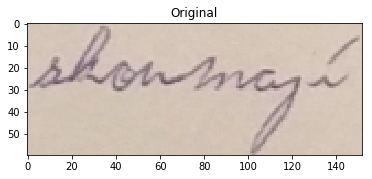

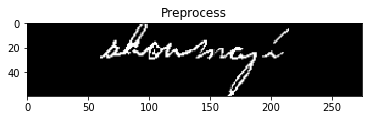

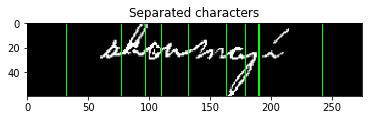

Index: 17


In [10]:
#  Last index
# 141 - text
LAST_INDEX = 0
# Class cycling through text positions
cycler = Cycler(crop, bBoxes, LAST_INDEX)

In [8]:
### LABELING ###
#
#  When image is shown click on "Label Image" for labeling
#                            or "Next Image" for next image
#  Then will be show the word slices, label them as "letter" or "gap"
#       - complete the labeling for whole word and repeat
#
################

### RULES FOR CREATING DATASET ###
#
#  Label every image
#  Slider is moving by 2px
#  For each gap creat around 3 images (before, center, after)
#
###################################

### Space for Notes ###
#
#  Try to tilt the sliding frame
#  Or when separated, tilt saparation lines +/- 45°,
#  so that it minimize the crossing pixels
#  (maximize number of white pixels in region???)
#
#######################